In [1]:
# ---- Includes ----

import re
import nltk
import spacy
import pickle
import optuna
import scikitplot
import matplotlib
import unicodedata

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

nltk.download("punkt")         # Download to be able to use word_tokenize from nltk library

!pip install optuna            # Download to be able to use Optuna as hyper-parameter
!python -m spacy download el   # Download to be able to lemmatize greek words using spacy
!pip install greek-stemmer-pos # Download to be able to use stem on greek words

from tabulate import tabulate
from wordcloud import WordCloud
from collections import Counter
from greek_stemmer import stemmer

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import cross_validate, GridSearchCV, train_test_split, learning_curve
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, accuracy_score, roc_auc_score

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
⚠ As of spaCy v3.0, shortcuts like 'el' are deprecated. Please use the
full pipeline package name 'el_core_news_sm' instead.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 68.3 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('el_core_news_sm')
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 227.5/227.5 kB 6.0 MB/s eta 0:00:00


Datasets

In [2]:
# ---- Reading the datasets ----

df_test = pd.read_csv("/kaggle/input/ys19-2023-assignment-1/test_set.csv")
df_train = pd.read_csv("/kaggle/input/ys19-2023-assignment-1/train_set.csv")
df_valid = pd.read_csv("/kaggle/input/ys19-2023-assignment-1/valid_set.csv")

# If you want to see the columns
# df_train.head(10)
# df_valid.head(10)

Data pre-processing

In [3]:
# ---- NaN values ----

df_test.dropna(inplace = True)   # Good practice to
df_train.dropna(inplace = True)  # remove all empty   
df_valid.dropna(inplace = True)  # values of the datasets

In [4]:
# ---- Stopwords ----

nltk.download("stopwords")
nlp = spacy.load('el_core_news_sm')

spacy_greek_stopwords = nlp.Defaults.stop_words       # Greek stopwords from spacy
nltk_greek_stopwords = set(stopwords.words("greek"))  # Greek stopwords from nltk

english_stopwords = set(stopwords.words("english"))
greek_stopwords = spacy_greek_stopwords.union(nltk_greek_stopwords) # Combination of those so there is a bigger list of stopwords

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [5]:
# ---- Cleansing / Tokenizing ----

mapping_names = {
    "αλεξη" : "αλεξης",
    "τσιπρα" : "τσιπρας",
    "συριζας" : "συριζα",
    "κουλη" : "κυριακος",
    "κουλης" : "κυριακος",
    "κυριακο" : "κυριακος",
    "μητσοτακη" : "μητσοτακης",
}

def replace_words(text):
    words = text.split()                                                # If the word is inside the dictionary (map for names)
    replaced_words = [mapping_names.get(word, word) for word in words]  # change it. Lemmatizer can't convert those names and if 
    return ' '.join(replaced_words)                                     # there's no usage of lemmatizer names must be equal

def split_connected(text):
    english_letters = r'[A-Za-z]+'
    greek_letters = r'[Α-Ωα-ωίϊΐόάέύϋΰήώ]+'
    
    greek = re.findall(greek_letters, text)     # Go and find the greek and the english 
    english = re.findall(english_letters, text) # words based on the patern above
    
    return ' '.join(english + greek)  # End combine them to have cleaner text. For example "Greekεκλογες" will be "Greek εκλογες"

def remove_accent(text):
    normalized = unicodedata.normalize('NFD', text)                              # Using unicodedata to decompose characters
    new_text = [char for char in normalized if not unicodedata.combining(char)]  # with tones or any accent and be able to keep
    return ''.join(new_text)

def stem_text(text):
    words = text.split()                                               # Split the text into words
    stemmed_words = [stemmer.stem_word(word,"VBG") for word in words]  # stem every word of the text 
    return ' '.join(stemmed_words)                                     # and join all text pieces

def lemmatize_text(text):
    tokens = nlp(text)                                     # Tokenize the text
    lemmatized_words = [token.lemma_ for token in tokens]  # then apply lemmatization
    return ' '.join(lemmatized_words)                      # and join all the tokens

def text_cleaning(column):
    column = column.str.lower()                                # All to lowercase first
    column = column.str.replace(r'[@#]', '', regex = True)     # Remove all mentions and hashtags
    column = column.str.replace(r'www\S+', '', regex = True)   # Remove anything that 
    column = column.str.replace(r'http\S+', '', regex = True)  # has to do with links 
    column = column.str.replace(r'[^\w\s]', '', regex = True)  # Remove all punctuation marks
       
    column = column.apply(split_connected)
    
    column = column.apply(lambda x: ' '.join(x.split())) # Replace consecutive whitespaces so the resulting description will contain a single space between words
    column = column.apply(lambda x: re.sub(r'(.)\1{2,}', r'\1\1', x)) # Replace 3 or more same consecutive characters by 2 using regular expressions (e.g balll will become ball)
    column = column.apply(lambda x: ' '.join([word for word in x.split() if word not in greek_stopwords]))   # Remove greek stopwords
    column = column.apply(lambda x: ' '.join([word for word in x.split() if word not in english_stopwords])) # Remove english stopwords

#     column = column.apply(stem_text)
#     column = column.str.lower()
#     column = column.apply(lemmatize_text)
    column = column.apply(remove_accent)
    column = column.apply(replace_words)
    
    return column

df_test['Text'] = text_cleaning(df_test['Text'])
df_train['Text'] = text_cleaning(df_train['Text'])
df_valid['Text'] = text_cleaning(df_valid['Text'])

df_train['Tokens'] = df_train['Text'].apply(word_tokenize)

Data Analysis

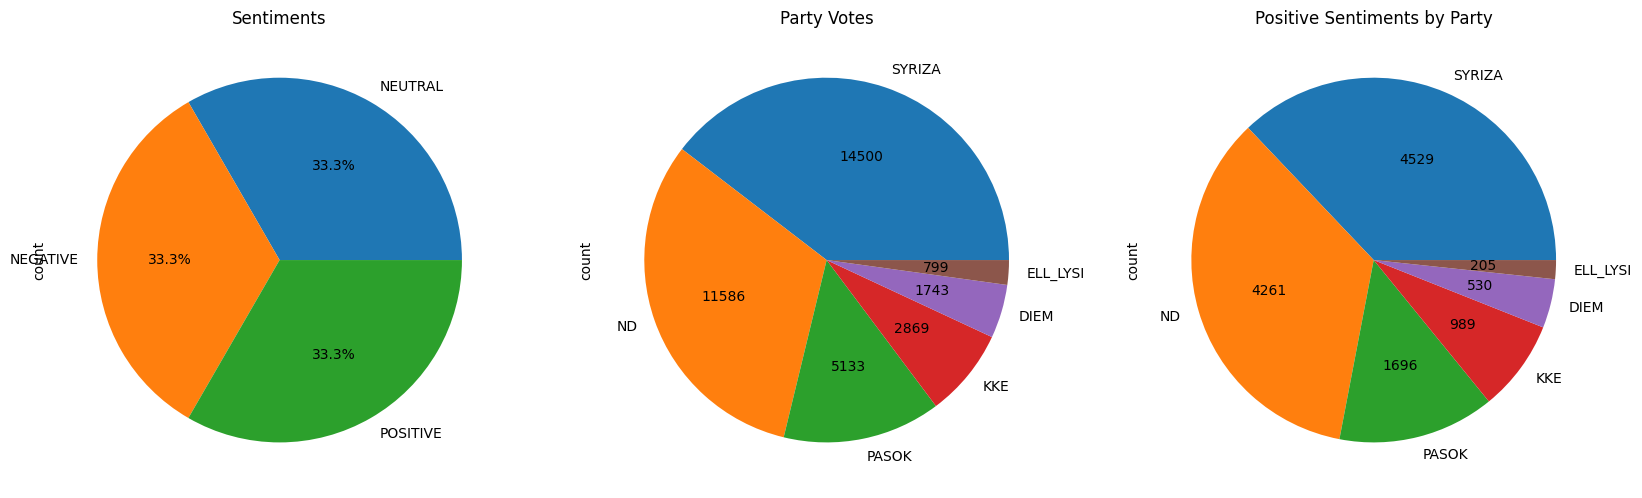

In [6]:
# ---- Pie Plots ----

plt.figure(figsize = (20, 8))

# What is the distribution of the sentiment
total_sentiment_distribution = df_train['Sentiment'].value_counts()

plt.subplot(1, 3, 1)
total_sentiment_distribution.plot(kind = 'pie', autopct = '%1.1f%%')
plt.title('Sentiments')

# Whats the total votes every party has
total_votes_party = df_train['Party'].value_counts()

plt.subplot(1, 3, 2)
total_votes_party.plot(kind = 'pie', autopct = lambda p: '{:.0f}'.format(p * total_votes_party.sum() / 100))
plt.title('Party Votes')

# How many positive sentiments each party has
positive_sentiment_party = df_train[df_train['Sentiment'] == 'POSITIVE']['Party'].value_counts()

plt.subplot(1, 3, 3)
positive_sentiment_party.plot(kind = 'pie', autopct = lambda p: '{:.0f}'.format(p * positive_sentiment_party.sum() / 100))
plt.title('Positive Sentiments by Party')

# Show all analysis #
plt.show()

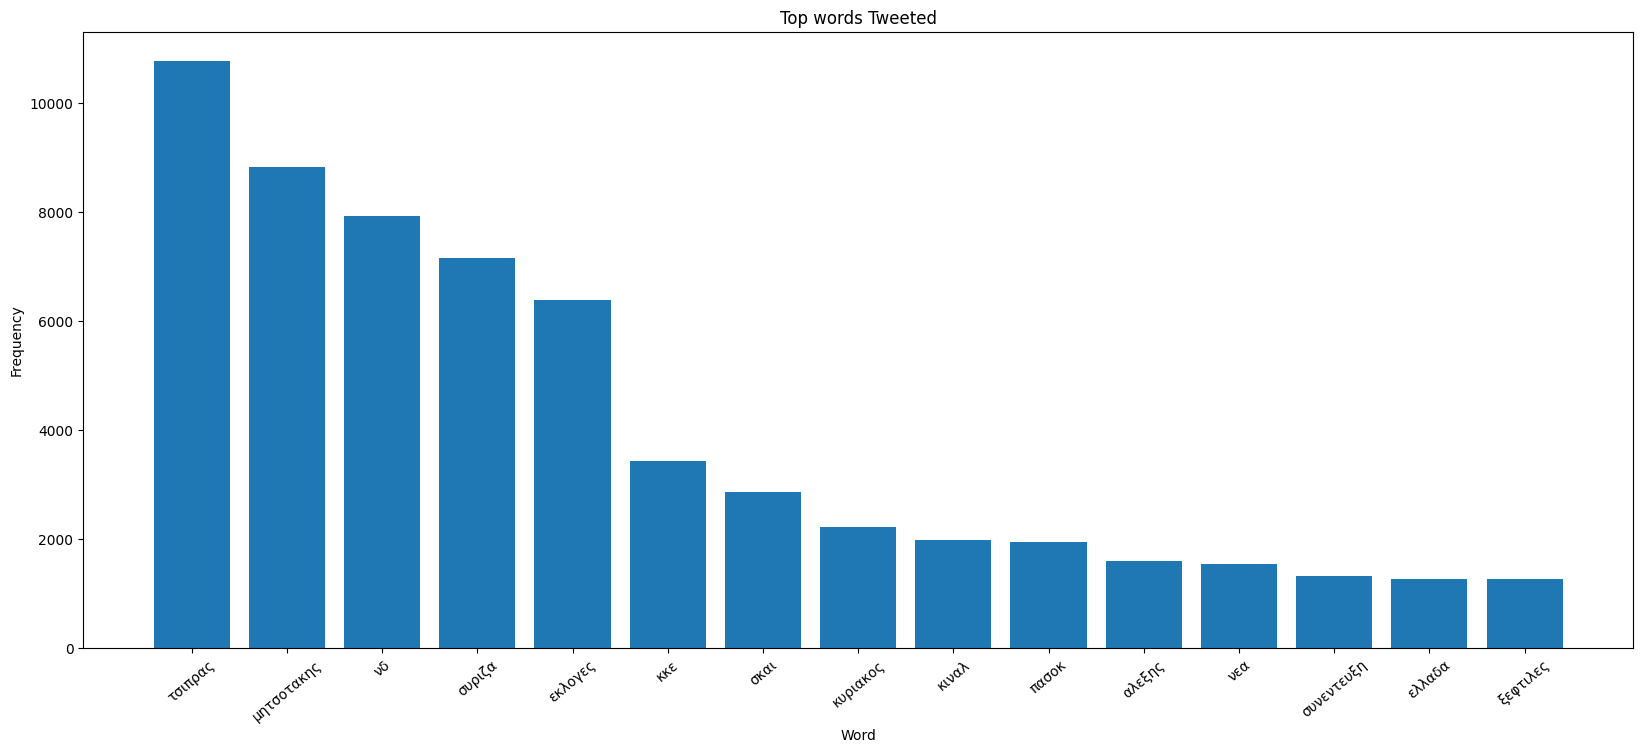

In [7]:
# ---- Bar Plots ----

plt.figure(figsize = (20, 8))

def find_top_words(column):
    count = Counter(word for words in column for word in words)      # Calculate word frequencies using Counter
    top_words = count.most_common(15)                                # and select the top 10 of them to show
    return pd.DataFrame(top_words, columns = ['Word', 'Frequency'])  # Create a DataFrame for plotting

# Top words used on Tweeter for the Greek Elections 
top_tweet_words = find_top_words(df_train['Tokens'])

plt.bar(top_tweet_words['Word'], top_tweet_words['Frequency'])
plt.xticks(rotation = 40)
plt.title('Top words Tweeted')
plt.xlabel('Word')
plt.ylabel('Frequency')

# Show all analysis #
plt.show()

Text(0.5, 1.0, 'WordCloud')

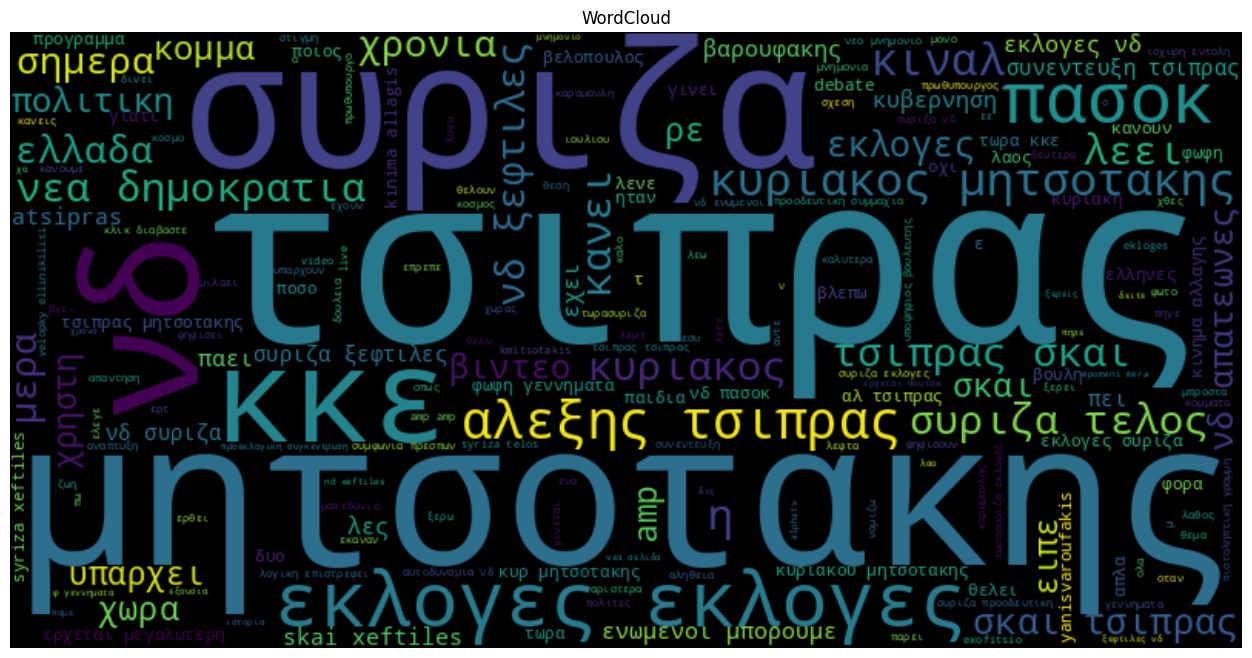

In [8]:
# ---- WordCloud for all dataset's text ----

plt.figure(figsize = (20, 8))

cloud = WordCloud(width = 800, height = 400, background_color = 'black').generate(' '.join(df_train['Text']))

plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('WordCloud')

<Figure size 2000x500 with 0 Axes>

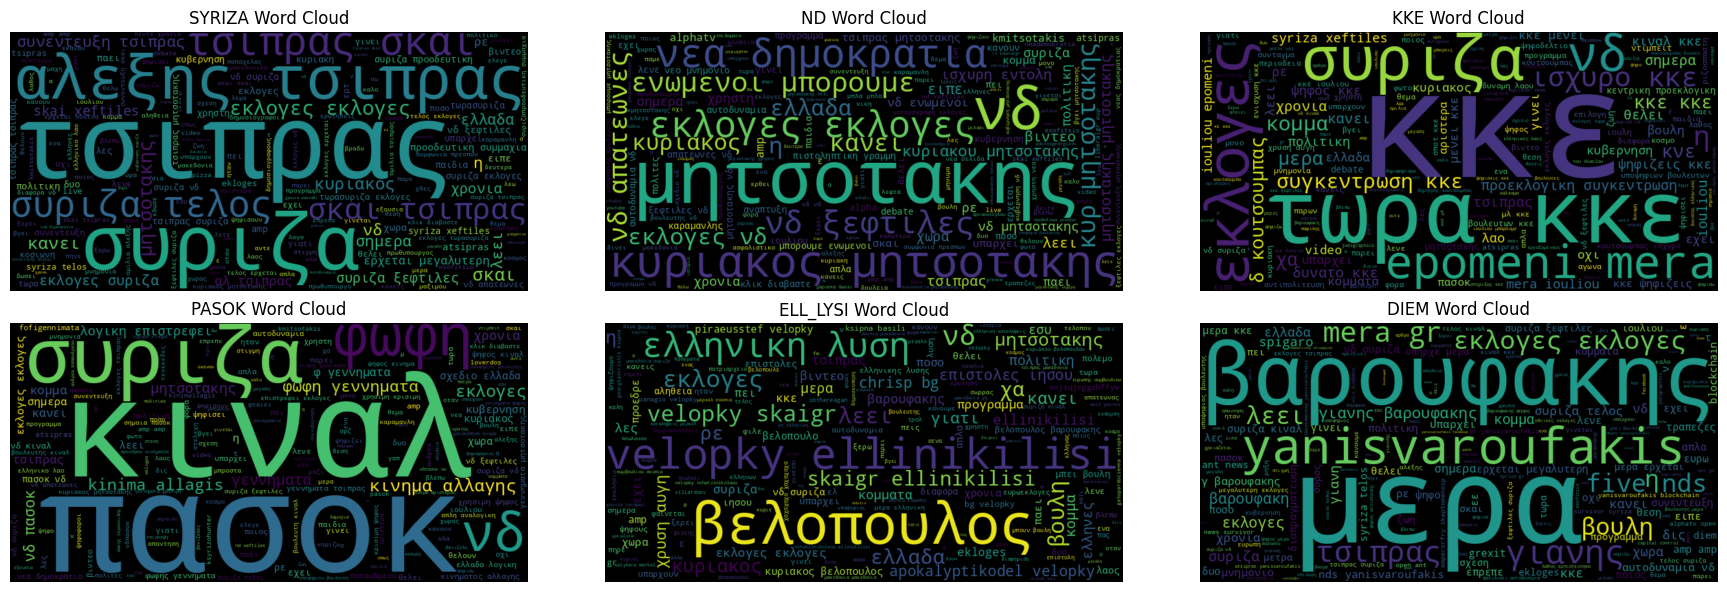

In [9]:
# ---- WordCloud for each Party ----

plt.figure(figsize = (20, 5))

parties = df_train['Party'].unique()

fig, axes = plt.subplots(nrows = (len(parties) // 3) + (len(parties) % 3 > 0), ncols = 3, figsize = (18, 6)) # Many word clouds so split for plotting

for i, party in enumerate(parties, start = 1):
    cloud = WordCloud(width = 800, height = 400, background_color = 'black').generate(' '.join(df_train[df_train['Party'] == party]['Text']))
    
    if len(parties) > 3:    # In a dataset im not
        row = (i - 1) // 3  # sure how many parties there 
        col = (i - 1) % 3   # are maybe it will come in handy
        ax = axes[row, col]
    else:
        ax = axes[i - 1]
    
    ax.imshow(cloud, interpolation = 'bilinear')
    ax.axis('off')
    ax.set_title(f'{party} Word Cloud')

plt.tight_layout()
plt.show()

<Figure size 2000x500 with 0 Axes>

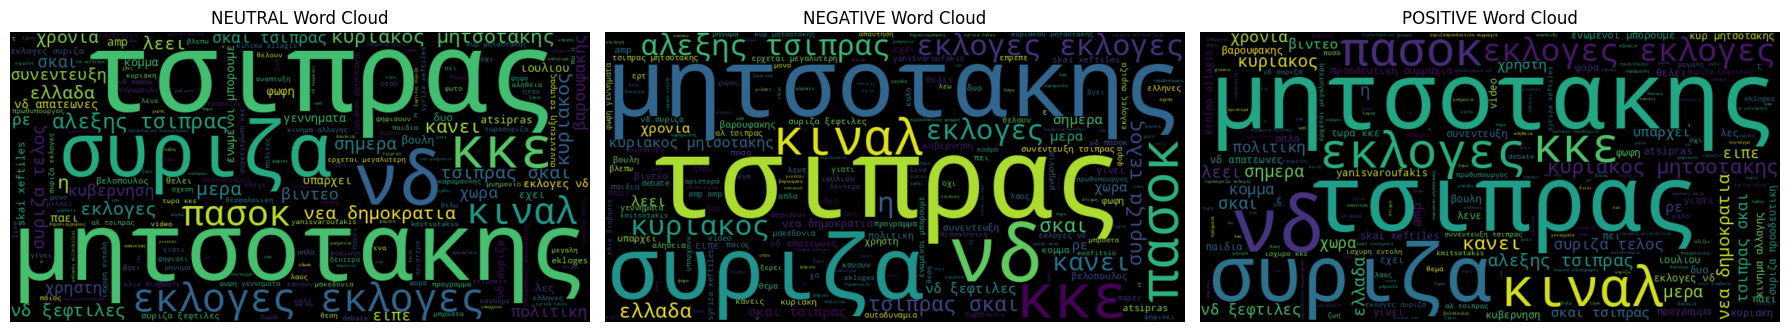

In [10]:
# ---- WordCloud for each Sentiment ----

plt.figure(figsize = (20, 5))

sentiments = df_train['Sentiment'].unique()

fig, axes = plt.subplots(nrows = (len(sentiments) // 3) + (len(sentiments) % 3 > 0), ncols = 3, figsize = (18, 6))

for i, sentiment in enumerate(sentiments, start = 1):
    cloud = WordCloud(width = 800, height = 400, background_color = 'black').generate(' '.join(df_train[df_train['Sentiment'] == sentiment]['Text']))
    
    if len(sentiments) > 3: # In a dataset im not
        row = (i - 1) // 3  # sure how many sentiments there
        col = (i - 1) % 3   # are maybe it will come in handy
        ax = axes[row, col]
    else:
        ax = axes[i - 1]
    
    ax.imshow(cloud, interpolation = 'bilinear')
    ax.axis('off')
    ax.set_title(f'{sentiment} Word Cloud')

plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Top 3 Parties Word Cloud')

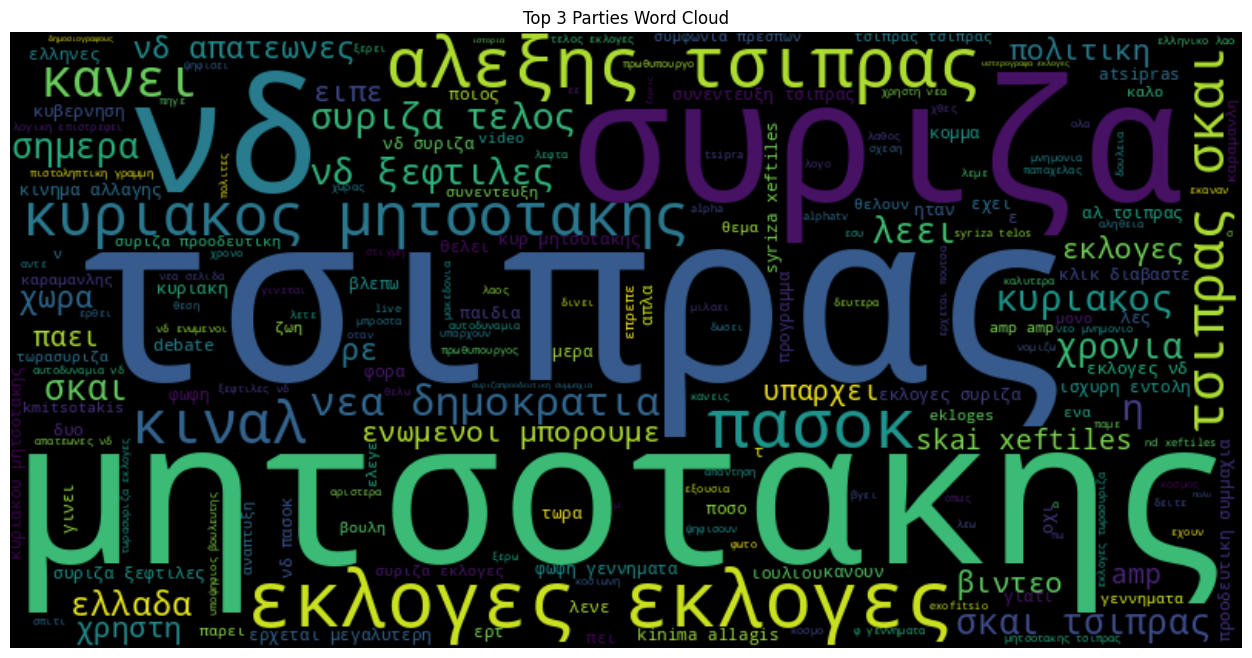

In [11]:
# ---- Word Cloud based on parties ----

plt.figure(figsize = (20, 8))

# WordCloud for the top 3 Political Parties
column = df_train[df_train['Party'].isin(['SYRIZA', 'ND', 'PASOK'])]['Text']
cloud = WordCloud(width = 800, height = 400, background_color = 'black').generate(' '.join(column))

plt.imshow(cloud, interpolation = 'bilinear')
plt.axis('off')
plt.title('Top 3 Parties Word Cloud')

Data partitioning

In [12]:
# ---- Train / Valid (Test) ----  

X_train = df_train['Text']
Y_train = df_train['Sentiment']  # Vectorizer can handle the sentiments

X_valid = df_valid['Text']
Y_valid = df_valid['Sentiment']

Vectorization

In [13]:
# ---- Fit & Transform ----

vectorizer = TfidfVectorizer()
# vectorizer = CountVectorizer() 
train_features = vectorizer.fit_transform(X_train)  # Fit and transform the X_train 
valid_features = vectorizer.transform(X_valid)      # Transform the X_valid

Classification

In [14]:
# ---- Scores to be calculated based on the model ----

scoring = {'precision' : make_scorer(precision_score, average = 'macro', zero_division = 1),
           'recall' : make_scorer(recall_score, average = 'macro', zero_division = 1),
           'f1' : make_scorer(f1_score, average = 'macro', zero_division = 1), 
           'accuracy' : 'accuracy'}

In [15]:
# ---- Model creation-training and results ----

model = LogisticRegression(max_iter = 1000)  # Using Logistic regression as classification algorithm    
model.fit(train_features, np.ravel(Y_train))

accuracy = accuracy_score(np.ravel(Y_valid), model.predict(valid_features))
f1 = f1_score(np.ravel(Y_valid), model.predict(valid_features), average = 'macro')                 # To have better match using
recall = recall_score(np.ravel(Y_valid), model.predict(valid_features), average = 'macro')         # macro both to predict 
precision = precision_score(np.ravel(Y_valid), model.predict(valid_features), average = 'macro')   # and to the cross validation
                          
valid_scores = cross_validate(model, valid_features, np.ravel(Y_valid), cv = 10, scoring = scoring)

table = [["Method", "Accuracy", "F1-Score", "Recall", "Precision"],
         ["Predict", accuracy, f1, recall, precision],
         ["Cross Validation", valid_scores['test_accuracy'].mean(), valid_scores['test_f1'].mean(), valid_scores['test_recall'].mean(), valid_scores['test_precision'].mean()]]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒══════════════════╤════════════╤════════════╤══════════╤═════════════╕
│ Method           │   Accuracy │   F1-Score │   Recall │   Precision │
╞══════════════════╪════════════╪════════════╪══════════╪═════════════╡
│ Predict          │   0.384748 │   0.384847 │ 0.384748 │    0.385568 │
├──────────────────┼────────────┼────────────┼──────────┼─────────────┤
│ Cross Validation │   0.386466 │   0.386214 │ 0.38647  │    0.386892 │
╘══════════════════╧════════════╧════════════╧══════════╧═════════════╛


Hyper-parameters

In [16]:
# ---- Using GridSearch ----

parameters = {'C': [0.01, 0.1, 1], 'solver': ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'], 'max_iter': [1000, 10000]} # All the wanted parameters want to check
grid_search = GridSearchCV(LogisticRegression(), parameters, cv = 10, scoring = 'accuracy')
grid_search.fit(train_features, np.ravel(Y_train))
best_parameters = grid_search.best_params_

best_c_grid = best_parameters['C']
best_solver_grid = best_parameters['solver']
best_iteration_grid = best_parameters['max_iter']

print("Best parameters: ", best_parameters)

Best parameters:  {'C': 0.1, 'max_iter': 1000, 'solver': 'liblinear'}


In [17]:
# ---- Using Optuna ----

def objective(trial):
    C = trial.suggest_float('C', 1e-3, 1e3, log = True)
    max_iter = trial.suggest_int('max_iter', 1000, 10000)
    solver = trial.suggest_categorical('solver', ['lbfgs', 'liblinear', 'newton-cg', 'sag', 'saga'])
    
    model = LogisticRegression(C = C, solver = solver, max_iter = max_iter)
    model.fit(train_features, np.ravel(Y_train))
    
    scores = cross_validate(model, valid_features, np.ravel(Y_valid), cv = 10, scoring = 'accuracy')  # in order to have trusted scores using cross
    
    return scores['test_score'].mean()
    
study = optuna.create_study(direction = 'maximize', study_name = 'Christos study')
study.optimize(objective, n_trials = 100)
best_parameters = study.best_params

best_c_optuna = best_parameters['C']
best_solver_optuna = best_parameters['solver']
best_iteration_optuna = best_parameters['max_iter']

print("Best hyperparameters:", best_parameters)

[I 2023-11-14 13:34:17,532] A new study created in memory with name: Christos study
[I 2023-11-14 13:34:21,271] Trial 0 finished with value: 0.38971290120123186 and parameters: {'C': 1.0128295192152108, 'max_iter': 6740, 'solver': 'liblinear'}. Best is trial 0 with value: 0.38971290120123186.
[I 2023-11-14 13:34:47,474] Trial 1 finished with value: 0.38054493307839393 and parameters: {'C': 30.659965353707285, 'max_iter': 2189, 'solver': 'newton-cg'}. Best is trial 0 with value: 0.38971290120123186.
[I 2023-11-14 13:35:03,456] Trial 2 finished with value: 0.3788233619896954 and parameters: {'C': 75.77934869035757, 'max_iter': 3571, 'solver': 'sag'}. Best is trial 0 with value: 0.38971290120123186.
[I 2023-11-14 13:35:05,740] Trial 3 finished with value: 0.3943050953833579 and parameters: {'C': 0.13203439873023964, 'max_iter': 8268, 'solver': 'liblinear'}. Best is trial 3 with value: 0.3943050953833579.
[I 2023-11-14 13:35:38,773] Trial 4 finished with value: 0.3746190503991943 and param

Best hyperparameters: {'C': 0.2506148907265962, 'max_iter': 6249, 'solver': 'lbfgs'}


Classification using Hyper-parameters

In [18]:
# ---- Model creation and results using Grid Search's best parameters ----

model = LogisticRegression(C = best_c_grid, solver = best_solver_grid, max_iter = best_iteration_grid) # Using Logistic regression as classification algorithm          
model.fit(train_features, np.ravel(Y_train))

accuracy = accuracy_score(np.ravel(Y_valid), model.predict(valid_features))
f1 = f1_score(np.ravel(Y_valid), model.predict(valid_features), average = 'macro')                 # To have better match using
recall = recall_score(np.ravel(Y_valid), model.predict(valid_features), average = 'macro')         # macro both to predict 
precision = precision_score(np.ravel(Y_valid), model.predict(valid_features), average = 'macro')   # and to the cross validation                 
                          
valid_scores = cross_validate(model, valid_features, np.ravel(Y_valid), cv = 10, scoring = scoring)

table = [["Method", "Accuracy", "F1-Score", "Recall", "Precision"],
         ["Predict", accuracy, f1, recall, precision],
         ["Cross Validation", valid_scores['test_accuracy'].mean(), valid_scores['test_f1'].mean(), valid_scores['test_recall'].mean(), valid_scores['test_precision'].mean()]]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒══════════════════╤════════════╤════════════╤══════════╤═════════════╕
│ Method           │   Accuracy │   F1-Score │   Recall │   Precision │
╞══════════════════╪════════════╪════════════╪══════════╪═════════════╡
│ Predict          │   0.402905 │   0.399412 │ 0.402905 │    0.405335 │
├──────────────────┼────────────┼────────────┼──────────┼─────────────┤
│ Cross Validation │   0.395834 │   0.394324 │ 0.395839 │    0.3962   │
╘══════════════════╧════════════╧════════════╧══════════╧═════════════╛


In [19]:
# ---- Model creation and results using Optuna's best parameters ----

model = LogisticRegression(C = best_c_optuna, solver = best_solver_optuna, max_iter = best_iteration_optuna) # Using Logistic regression as classification algorithm          
model.fit(train_features, np.ravel(Y_train))

accuracy = accuracy_score(np.ravel(Y_valid), model.predict(valid_features))
f1 = f1_score(np.ravel(Y_valid), model.predict(valid_features), average = 'macro')                 # To have better match using
recall = recall_score(np.ravel(Y_valid), model.predict(valid_features), average = 'macro')         # macro both to predict 
precision = precision_score(np.ravel(Y_valid), model.predict(valid_features), average = 'macro')   # and to the cross validation                 
                          
valid_scores = cross_validate(model, valid_features, np.ravel(Y_valid), cv = 10, scoring = scoring)

table = [["Method", "Accuracy", "F1-Score", "Recall", "Precision"],
         ["Predict", accuracy, f1, recall, precision],
         ["Cross Validation", valid_scores['test_accuracy'].mean(), valid_scores['test_f1'].mean(), valid_scores['test_recall'].mean(), valid_scores['test_precision'].mean()]]

print(tabulate(table, headers = 'firstrow', tablefmt = 'fancy_grid'))

╒══════════════════╤════════════╤════════════╤══════════╤═════════════╕
│ Method           │   Accuracy │   F1-Score │   Recall │   Precision │
╞══════════════════╪════════════╪════════════╪══════════╪═════════════╡
│ Predict          │   0.398127 │   0.397447 │ 0.398127 │    0.399716 │
├──────────────────┼────────────┼────────────┼──────────┼─────────────┤
│ Cross Validation │   0.397935 │   0.397344 │ 0.397943 │    0.398354 │
╘══════════════════╧════════════╧════════════╧══════════╧═════════════╛


AUC, Learning Curve, Confusion Matrix

Total AUC:  0.578


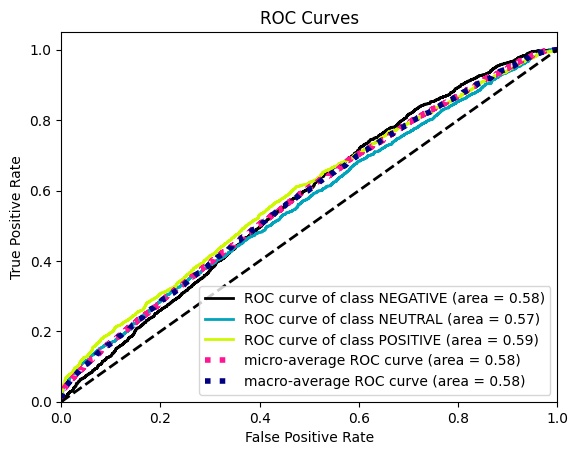

In [20]:
# ---- ROC Curve / AUC Score ----

auc = np.round(roc_auc_score(np.ravel(Y_valid), model.predict_proba(valid_features), multi_class = 'ovo'), 3)
print("Total AUC: ", auc)

scikitplot.metrics.plot_roc(np.ravel(Y_valid), model.predict_proba(valid_features))
plt.show()

F1 Score Train:  1.0
F1 Score Validation:  0.16652327693337157
F1 Score Train:  0.9415692400680019
F1 Score Validation:  0.37600070739636404
F1 Score Train:  0.8902386656945946
F1 Score Validation:  0.3730500384140823
F1 Score Train:  0.8550292238739643
F1 Score Validation:  0.383312864902706
F1 Score Train:  0.8359370169841703
F1 Score Validation:  0.38648360411294697
F1 Score Train:  0.8160194563947843
F1 Score Validation:  0.38432608818433894
F1 Score Train:  0.8028090351397497
F1 Score Validation:  0.384394133127599
F1 Score Train:  0.7870189448718626
F1 Score Validation:  0.39248688078009436
F1 Score Train:  0.7718314507938695
F1 Score Validation:  0.39201145044982244
F1 Score Train:  0.763461845679546
F1 Score Validation:  0.3924541494414131


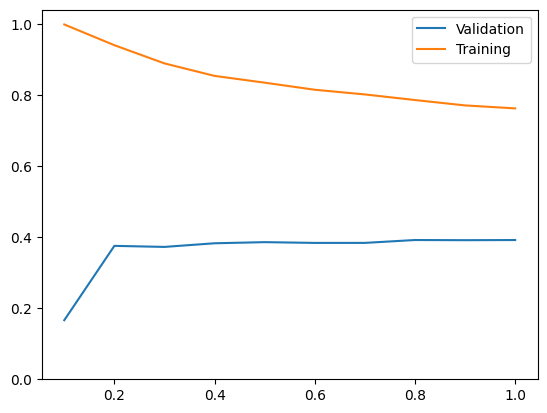

In [21]:
# ---- Learning Curve ----

list_samples = []
list_f1_train = []
list_f1_validation = []

for times in range(10):
    X, X_unused, Y, Y_unused = train_test_split(train_features, Y_train, test_size = 1 - (times * 0.1 + 0.001))

    model = LogisticRegression(max_iter = 1000)
#     model = LogisticRegression(C = best_c_optuna, solver = best_solver_optuna, max_iter = best_iteration_optuna) # For better results using the hyper-parameters
    model.fit(X, np.ravel(Y))

    f1_train = f1_score(np.ravel(Y), model.predict(X), average = 'macro')
    f1_validation = f1_score(np.ravel(Y_valid), model.predict(valid_features), average = 'macro')
    
    print("F1 Score Train: ", str(f1_train))
    print("F1 Score Validation: ", str(f1_validation))

    list_f1_train.append(f1_train)
    list_f1_validation.append(f1_validation)
    
    list_samples.append((times * 0.1 + 0.1))

plt.plot(list_samples, list_f1_validation)
plt.plot(list_samples, list_f1_train)

plt.ylim(ymin = 0)
plt.legend(["Validation", "Training"])

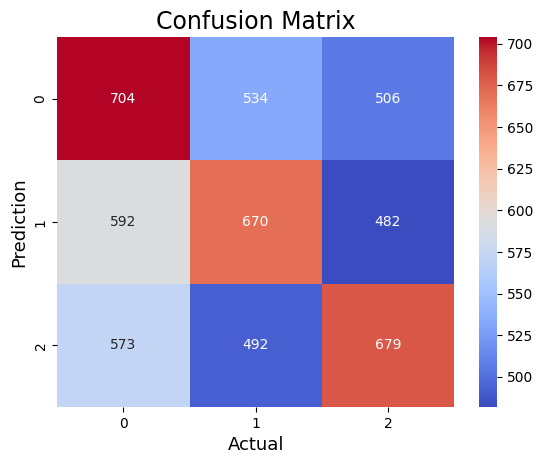

In [22]:
# ---- Confusion Matric ----

confusion_martix = metrics.confusion_matrix(np.ravel(Y_valid), model.predict(valid_features))

sns.heatmap(confusion_martix, annot = True, fmt = "d", cmap = 'coolwarm')
plt.ylabel('Prediction', fontsize = 13)
plt.xlabel('Actual', fontsize = 13)
plt.title('Confusion Matrix', fontsize = 17)
plt.show()

Final Predictions

In [ ]:
X_test = df_test['Text']

test_features = vectorizer.transform(X_test) # Transform the X_test like X_valid
predictions = model.predict(test_features)   # previously and based on the model make predictions

df_test['Sentiments'] = predictions

In [ ]:
df_predictions = df_test[['New_ID', 'Sentiments']]                                            # The dataset to output needs only
df_predictions = df_predictions.rename(columns = {'New_ID': 'Id', 'Sentiments': 'Predicted'}) # the 2 columns of sentiments and ids
df_predictions.to_csv("submission.csv", index = False)